In [ ]:
# === 0) Imports necesarios ===
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm


C:\Users\oriol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
# === 1) Leer y preparar los datos para el modelo, variable X y variable Y ===

df = pd.read_csv("ventas_mensuales - TUM-Mod-Cor.csv", sep=";", decimal=".", encoding="Latin1") #Leer el archicvo CSV con separador ; y codificación Latin1
df["date"] = pd.to_datetime(df["date"], format="%d/%m/%Y") #Convertir la columna 'date' a formato datetime
df = df.set_index("date") #Establecer la columna 'date' como índice 
df["value"] = pd.to_numeric(df["value"])#Convertir la columna 'value' a numérico
y = df["value"] #Asignar la columna 'value' a la variable y

In [3]:
# === 2) Condicional para modelar según si se tiene encuenta el COVID o no ===

covid = 0 # 0 = Sin datos de la etapa COVID; 1 = Con datos de la etapa COVID
COVID_START = "2020-03-01" # Fecha considerada de inicio del periodo COVID
COVID_END   = "2021-12-01" # Fecha considerada de fin del periodo COVID

# Condicional para enmascarar los datos del periodo COVID si covid == 0
if covid == 0:
    y_masked = y.copy()
    y_masked.loc[COVID_START:COVID_END] = np.nan
else:  
    y_masked = y.copy()


In [4]:
# === 3) Preparar las variables exógenas ===

#cols_exog = ["Sol","Precipitación","Agosto","Tendencia"]  # Sin festivos ni temperatura ni "ICC". Variables exógenas óptimas
cols_exog = ["Sol","Precipitación","Agosto","Tendencia","Festivos","Temperatura","ICC","Parasol_lag1","Sillas_lag1"]  # Con todas las variables exógenas disponibles.

for c in cols_exog: # Transformar y preparar las variables exógenas
    df[c] = df[c].astype(str) # Convertir a string para reemplazar comas
    df[c] = df[c].str.replace(",", ".", regex=False) # Reemplazar comas por puntos decimales
    df[c] = pd.to_numeric(df[c], errors="coerce") # Convertir a numérico, forzando errores a NaN

X = df[[c for c in cols_exog if c in df.columns]] # Crear la matriz de variables exógenas X

X_full = df[cols_exog]  # Crear la matriz completa de variables exógenas X_full

# Print para verificar tipos de datos y contenido
# print(df[cols_exog].dtypes)
# print(X_full.head())

In [5]:
# === 4) Definición de funciones para el cálculo de métricas de evaluación ===

# Root Mean Squared Error (RMSE)
def rmse(y_verd, y_pred):
    return np.sqrt(np.mean((y_pred - y_verd)**2))

# Mean Absolute Error (MAE) 
def mae(y_verd, y_pred):
    return np.mean(np.abs(y_pred - y_verd))

# Mean Absolute Percentage Error (MAPE) con denominador seguro
def mape_safe(y_verd, y_pred, eps=1.0):
    denom = np.maximum(np.abs(y_verd), eps)
    return np.mean(np.abs(y_pred - y_verd) / denom) * 100.0

# Symmetric Mean Absolute Percentage Error (SMAPE)
def smape(y_verd, y_pred, eps=1e-8):
    denom = np.abs(y_verd) + np.abs(y_pred)
    denom = np.where(denom < eps, eps, denom)
    return np.mean(2.0 * np.abs(y_pred - y_verd) / denom) * 100.0

# Weighted Absolute Percentage Error (WAPE)
def wape(y_verd, y_pred, eps=1e-8):
    return np.sum(np.abs(y_pred - y_verd)) / max(np.sum(np.abs(y_verd)), eps) * 100.0

# Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y_verd, y_pred):
    yt = np.log1p(np.maximum(y_verd, 0))
    yp = np.log1p(np.maximum(y_pred, 0))
    return np.sqrt(np.mean((yp - yt)**2))

# R-squared (R2) Score
def r2_score(y_verd, y_pred):
    var = np.var(y_verd)
    if var <= 0:
        return np.nan
    return 1.0 - np.sum((y_pred - y_verd)**2) / np.sum((y_verd - np.mean(y_verd))**2)

# Función para calcular todas las métricas anteriores
def metricas (y_verd, y_pred, eps_mape=1.0, prefix=""):
    return {
        f"{prefix}R2": r2_score(y_verd, y_pred),
        f"{prefix}RMSLE": rmsle(y_verd, y_pred),
        f"{prefix}RMSE": rmse(y_verd, y_pred),
        f"{prefix}MAE": mae(y_verd, y_pred),
        f"{prefix}MAPE_safe(%)": mape_safe(y_verd, y_pred, eps=eps_mape),
        f"{prefix}SMAPE(%)": smape(y_verd, y_pred),
        f"{prefix}WAPE(%)": wape(y_verd, y_pred),
    }


In [6]:
# === 5a) Valores constantes de los hiperparmámetros

CPS = 0.3         # changepoint_prior_scale
SPS = 1         # seasonality_prior_scale
SPS_CONST = 3    # seasonality_prior_scale constante en el modelo final         
# MONTHLY_ORDER = 3  # Fourier para mensual (Se comenta porque no se usa estacionalidad mensual)
YEARLY_ORDER=10 # Fourier para anual
YEARLY_ORDER_CONST=10 # Fourier anual constante en el modelo final      # changepoint_prior_scale  
REGRESSOR_PRIOR = 10   # prior scale para regresores exógenos
REGRESSOR_PRIOR_CONST = 2 # prior scale constante para regresores exógenos en el modelo final
PRIORS_BASE = {"Precipitación":10, "Agosto":10, "Sol":10, "Tendencia":10} # Priors base para cada variable exógena
priors_map = {r: REGRESSOR_PRIOR * PRIORS_BASE.get(r, 1.0) for r in cols_exog} # Mapa de priors para cada variable exógena

In [7]:
# === 5b) Preparar los conjuntos de entrenamiento y prueba ===

df_full = X.copy(); # Crear una copia de X para evitar modificar el original
df_full['ds'] = y_masked.index; # Crear la columna de inidices para Prophet
df_full['y'] = y_masked.values # Crear la columna de valores objetivo para Prophet

# Crear el DataFrame completo uniendo X y y_masked, alineando por índice y eliminando filas sin y que en este caso son las del periodo COVID si covid == 0
df_full = (
    X.join(y_masked.rename('y'))   # alinea por índice
     .reset_index(names='ds')      # el índice pasa a columna 'ds'
     .dropna(subset=['y'])         # quita filas sin y (para covid==0, las del periodo COVID)
)

# Dividir en conjuntos de entrenamiento y prueba (80% - 20%)
split = int(len(df_full) * 0.80) # Índice de división
train = df_full.iloc[:split].copy() # Conjunto de entrenamiento
test  = df_full.iloc[split:].copy() # Conjunto de prueba

# Se necesita más adelante para calculo de residuos
train_log = np.log(np.clip(train['y'], 1e-6, None)) # Aplicar logaritmo con gestión para para evitar log(0)
test_log  = np.log(np.clip(test['y'],  1e-6, None)) # Aplicar logaritmo con gestión para para evitar log(0)

In [8]:
# === 6) Configurar, entrenar y predecir con el modelo Prophet ===

def ejecutar_modelo_prophet(train, test, exogs, CPS, SPS, REGRESSOR_PRIOR):
   
    train_log = train.copy() # Crear copias de los conjuntos de entrenamiento 
    test_log = test.copy() # Crear copias de los conjuntos de prueba

    train_log['y'] = np.log(np.clip(train_log['y'], 1e-6, None)) # Aplicar logaritmo con gestión para para evitar log(0)
    test_log['y']  = np.log(np.clip(test_log['y'],  1e-6, None)) # Aplicar logaritmo con gestión para para evitar log(0)

    m = Prophet(
       
        seasonality_mode='additive', # Tipo de estacionalidad
        changepoint_prior_scale=CPS, # Escala de prior para puntos de cambio
        seasonality_prior_scale=SPS, # Escala de prior para estacionalidad
        interval_width=0.95 # Intervalo de confianza del 95%

    )

    m.add_seasonality(name='anual', period=365.25, fourier_order=YEARLY_ORDER) # Añadir estacionalidad anual con Fourier
    # m.add_seasonality(name="mensual", period=30.5, fourier_order=MONTHLY_ORDER)  # Añadir estacionalidad mensual con Fourier, no usada aquí
    
    exogs = exogs or [] # Asegurarse de que exogs es una lista, incluso si es None

    # Añadir regresores externos   
    for r in exogs:
        m.add_regressor(r, prior_scale=priors_map.get(r, REGRESSOR_PRIOR), standardize=True)

    # Entrenamiento del modelo con datos en log, ya que se está modelando en escala logarítmica
    m.fit(train_log[['ds', 'y'] + exogs]) # ds es el índice de fechas, y es la variable objetivo en escala logarítmica y cols_exog son las variables exógenas

    # Predecciones utilizando el modelo entrenado en el horizonte de test
    predicciones = m.predict(test_log[['ds'] + exogs])[['ds','yhat','yhat_lower','yhat_upper']] # Solo se necesitan las columnas 'ds' y 'yhat', yhat es un nombre estándar en Prophet que es el resultado predicho
    

    # Unir predicción con valores reales mediante la columna 'ds'
    inner_join = test_log[['ds','y']].merge(predicciones, on='ds', how='inner')
    y_real_lin = np.exp(inner_join['y'].to_numpy())      # deshacer log de y real
    y_pred_lin = np.exp(inner_join['yhat'].to_numpy())   # deshacer log de yhat
    inner_join['y_lin']     = np.exp(inner_join['y']) # deshacer log de y real
    inner_join['yhat_lin']  = np.exp(inner_join['yhat']) # deshacer log de yhat
    inner_join['lo_lin']    = np.exp(inner_join['yhat_lower']) # deshacer log de yhat_lower
    inner_join['hi_lin']    = np.exp(inner_join['yhat_upper']) # deshacer log de yhat_upper

    index_values = inner_join['ds'].values # Índices de fechas para el conjunto de prueba

    metrics = metricas(y_real_lin, y_pred_lin, eps_mape=1.0)# Calcular métricas de evaluación

    # Resultado final en un DataFrame conjunto
    # result = inner_join.assign(y_pred_normalizada=y_pred_lin)
    # print(result.head())  # Mostrar las primeras filas del DataFrame resultante

    return m, index_values, y_real_lin, y_pred_lin, metrics,inner_join

m, index_values, y_real_lin, y_pred_lin, metrics,inner_join = ejecutar_modelo_prophet(train, test, cols_exog,CPS, SPS, REGRESSOR_PRIOR)


23:07:19 - cmdstanpy - INFO - Chain [1] start processing
23:07:19 - cmdstanpy - INFO - Chain [1] done processing


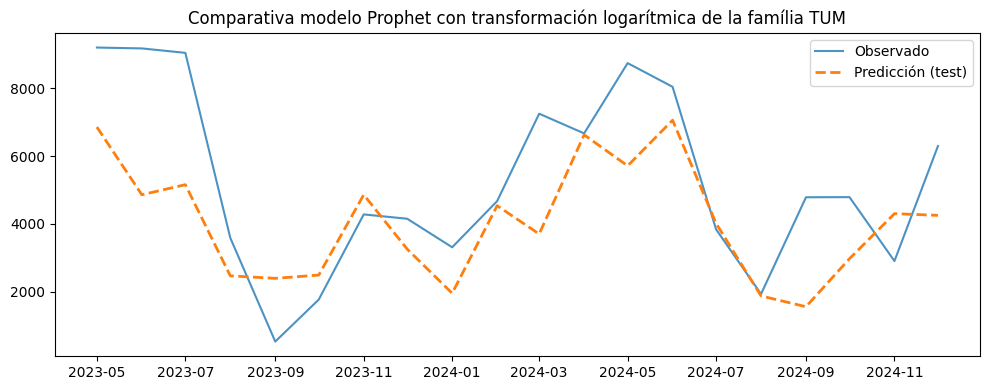

In [9]:
# === 7) Visualización de resultados comparando observado vs predicción modelo sin optimizar ===

plt.figure(figsize=(10,4))
plt.plot(index_values, y_real_lin, label="Observado", alpha=0.8)
plt.plot(index_values, y_pred_lin, "--", label="Predicción (test)", linewidth=2)
plt.title("Comparativa modelo Prophet con transformación logarítmica de la família TUM")
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
# === 8) Elección de variables exógenas mediante ablación ===

rows = [] # Lista para almacenar resultados de ablación
for reg in cols_exog:
    exogs = [c for c in cols_exog if c != reg] # Excluir la variable actual
    _, _, _, _, metrics,_ = ejecutar_modelo_prophet(train, test, exogs,CPS, SPS, REGRESSOR_PRIOR) # Llamar a la función con las variables exógenas restantes
    rows.append({'drop': reg, **metrics}) # Almacenar el resultado con la variable eliminada
ablation_df = pd.DataFrame(rows).sort_values('RMSE') # Mostrar el DataFrame de ablación ordenado por RMSE
ablation_df # Mostrar el DataFrame de ablación ordenado por RMSE

23:07:19 - cmdstanpy - INFO - Chain [1] start processing
23:07:20 - cmdstanpy - INFO - Chain [1] done processing
23:07:20 - cmdstanpy - INFO - Chain [1] start processing
23:07:20 - cmdstanpy - INFO - Chain [1] done processing
23:07:20 - cmdstanpy - INFO - Chain [1] start processing
23:07:21 - cmdstanpy - INFO - Chain [1] done processing
23:07:21 - cmdstanpy - INFO - Chain [1] start processing
23:07:21 - cmdstanpy - INFO - Chain [1] done processing
23:07:21 - cmdstanpy - INFO - Chain [1] start processing
23:07:22 - cmdstanpy - INFO - Chain [1] done processing
23:07:22 - cmdstanpy - INFO - Chain [1] start processing
23:07:22 - cmdstanpy - INFO - Chain [1] done processing
23:07:22 - cmdstanpy - INFO - Chain [1] start processing
23:07:23 - cmdstanpy - INFO - Chain [1] done processing
23:07:23 - cmdstanpy - INFO - Chain [1] start processing
23:07:23 - cmdstanpy - INFO - Chain [1] done processing
23:07:23 - cmdstanpy - INFO - Chain [1] start processing
23:07:24 - cmdstanpy - INFO - Chain [1]

,drop,R2,RMSLE,RMSE,MAE,MAPE_safe(%),SMAPE(%),WAPE(%)
3,Tendencia,0.566737,0.507712,1710.491353,1464.838508,45.475814,35.325276,27.895044
6,ICC,0.547849,0.509948,1747.377419,1516.704703,51.814825,34.644853,28.882737
4,Festivos,0.433735,0.529951,1955.485805,1567.754105,45.259449,37.542334,29.854875
0,Sol,0.426947,0.533521,1967.172414,1564.857458,44.888628,37.258357,29.799714
2,Agosto,0.362743,0.550780,2074.446889,1655.575970,45.977504,38.972066,31.527274
5,Temperatura,0.354590,0.540637,2087.674074,1651.249019,44.334000,38.630449,31.444875
7,Parasol_lag1,0.315455,0.556945,2150.036657,1719.696544,46.251675,40.105006,32.748327
8,Sillas_lag1,0.281519,0.565536,2202.685059,1759.685988,45.873121,41.211500,33.509850
1,Precipitación,0.239687,0.576271,2265.901539,1801.681349,45.476282,42.277714,34.309571


In [11]:
# === 9) Elección de variables exógenas mediante forward selection ===

# Función de forward selection
def forward_selection(train, test, candidates, max_k=None, metric='RMSE',fixed=None, CPS=CPS, SPS=SPS,  REGRESSOR_PRIOR=REGRESSOR_PRIOR):

    fixed = list(fixed or []) # Asegurar que 'fixed' es una lista
    pool = [c for c in candidates if c not in fixed] # Candidatas excluyendo las fijas
    selected = fixed[:]# Copia de las fijas
    best_score = None # Inicialización de la mejor puntuación incial
    history = [] # Historial de selecciones
    trials_log = [] # Lista de evaliaciones realizadas

    K = len(pool) if max_k is None else min(max_k, len(pool)) # Número máximo de iteraciones
    for step in range(1, K+1): # Iterar hasta K
        best_cand, best_mets = None, None # Inicializar el mejor candidato y métricas de la ronda
        for c in pool: # Iterar sobre las candidatas
            if c in selected: #
                continue
            trial = selected + [c] # Crear la lista de variables exógenas para esta prueba
            # Llamada de la función con keywords para no desplazar args
            _, _, _, _, mets, _ = ejecutar_modelo_prophet(
                train=train, test=test, exogs=trial,
                CPS=CPS, SPS=SPS,  REGRESSOR_PRIOR=REGRESSOR_PRIOR
            )
            # Guardar el resultado de la evaluación
            trials_log.append({'round': step, 'candidate': c, **mets}) # Almacenar el resultado de la evaluación
            # Selección del mejor de la ronda
            if (best_mets is None) or (mets[metric] < best_mets[metric]): # Comparar métricas para encontrar la mejor
                best_mets, best_cand = mets, c # Seleccionar el mejor candidato y sus métricas
        # Si no hay mejora, salir del bucle
        if best_cand is None:
            break
        # Comprobar si la mejor métrica mejora la mejor puntuación global
        if best_score is None or best_mets[metric] < best_score:
            selected.append(best_cand)
            best_score = best_mets[metric]
            history.append({'step': len(selected) - len(fixed), 'added': best_cand, **best_mets})
        else:
            break

    # Devolvemos sólo lo añadido respecto a las fijas
    added_only = [c for c in selected if c not in fixed]
    return added_only, pd.DataFrame(history), pd.DataFrame(trials_log)

# Variables fijas y candidatas
fijas = ["Sol","Precipitación","Agosto","Tendencia"]  # Exógenas optimizada ya en este momento.
cols_exog_añadir = ["Festivos","Temperatura","ICC"]  # Sin festivos ni Covid ni temperatura ni "ICC".
candidatas = cols_exog_añadir # Las variables candidatas

# Llamada de la función forward selection
added, hist, trials = forward_selection(
    train=train, test=test,
    candidates=cols_exog_añadir, fixed=fijas, metric='RMSE',
    CPS=CPS, SPS=SPS, REGRESSOR_PRIOR=REGRESSOR_PRIOR
)


23:07:24 - cmdstanpy - INFO - Chain [1] start processing
23:07:24 - cmdstanpy - INFO - Chain [1] done processing
23:07:24 - cmdstanpy - INFO - Chain [1] start processing
23:07:24 - cmdstanpy - INFO - Chain [1] done processing
23:07:24 - cmdstanpy - INFO - Chain [1] start processing
23:07:25 - cmdstanpy - INFO - Chain [1] done processing
23:07:25 - cmdstanpy - INFO - Chain [1] start processing
23:07:25 - cmdstanpy - INFO - Chain [1] done processing
23:07:25 - cmdstanpy - INFO - Chain [1] start processing
23:07:26 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
# === 10) Análisis de la escala de los priors de los regresores exógenos ===

cols_exog_optimas= ["Sol","Precipitación","Agosto","Tendencia","Parasol_lag1","Sillas_lag1"] # Variables exógenas óptimas tras forward selection y ablación 

PRIORS_BASE = {"Precipitación":10, "Agosto":10, "Sol":10, "Tendencia":10, "Parasol_lag1":10, "Sillas_lag1":10} # Prior scales base para las variables exógenas óptimas

EXOG_USE = cols_exog_optimas # Variables exógenas a usar en el análisis de escala de priors

# Función para entrenar y evaluar el modelo con una escala dada de priors
def entrenar_sps(priors_map, sps=SPS, yearly_order=YEARLY_ORDER_CONST, cps=CPS):
   
    train_log = train.copy() # Crear copias de los conjuntos de entrenamiento 
    test_log = test.copy() # Crear copias de los conjuntos de prueba
    train_log['y'] = np.log(np.clip(train_log['y'], 1e-6, None)) # Aplicar logaritmo con gestión para para evitar log(0)
    test_log['y']  = np.log(np.clip(test_log['y'],  1e-6, None)) # Aplicar logaritmo con gestión para para evitar log(0)
   
   # Definición del modelo Prophet
    m = Prophet(
       
        seasonality_mode='additive', # Tipo de estacionalidad
        changepoint_prior_scale=cps, # Escala de prior para puntos de cambio
        seasonality_prior_scale=sps # Escala de prior para estacionalidad
    )
    
    # Añadir estacionalidad anual con Fourier
    m.add_seasonality(name="yearly", period=365.25, fourier_order=yearly_order)
    
    # Añadir regresores externos con las escalas de prior dadas
    for r in EXOG_USE:
        m.add_regressor(r, prior_scale=priors_map.get(r, 0.8), standardize=True)
    
    # Entrenamiento del modelo con datos en log, ya que se está modelando en escala logarítmica
    m.fit(train_log[["ds","y"]+EXOG_USE])
    
    predicciones = m.predict(test_log[["ds"]+EXOG_USE])[["ds","yhat"]] # Solo se necesitan las columnas 'ds' y 'yhat', yhat es un nombre estándar en Prophet que es el resultado predicho
    evaluacion = test[["ds","y"]].merge(predicciones, on="ds") # Unir predicción con valores reales mediante la columna 'ds'
    yhat = np.exp(predicciones["yhat"].values) # Deshacer logaritmo de yhat
    mets = metricas(evaluacion["y"].values, yhat) # Calcular métricas de evaluación
    return mets

scales = [0.1, 0.3, 0.8, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0] # Escalas a probar
curva = [] # Lista para almacenar resultados de las diferentes escalas

# Iterar sobre las diferentes escalas y entrenar el modelo
for s in scales:
    pri = {k: v*s for k,v in PRIORS_BASE.items()}  # Miltiplicador global
    mets = entrenar_sps(pri, sps=SPS,yearly_order=YEARLY_ORDER_CONST, cps=CPS)
    curva.append({"scale": s, **mets})
pd.DataFrame(curva).sort_values("RMSE")

23:07:26 - cmdstanpy - INFO - Chain [1] start processing
23:07:26 - cmdstanpy - INFO - Chain [1] done processing
23:07:26 - cmdstanpy - INFO - Chain [1] start processing
23:07:26 - cmdstanpy - INFO - Chain [1] done processing
23:07:26 - cmdstanpy - INFO - Chain [1] start processing
23:07:27 - cmdstanpy - INFO - Chain [1] done processing
23:07:27 - cmdstanpy - INFO - Chain [1] start processing
23:07:27 - cmdstanpy - INFO - Chain [1] done processing
23:07:27 - cmdstanpy - INFO - Chain [1] start processing
23:07:28 - cmdstanpy - INFO - Chain [1] done processing
23:07:28 - cmdstanpy - INFO - Chain [1] start processing
23:07:28 - cmdstanpy - INFO - Chain [1] done processing
23:07:28 - cmdstanpy - INFO - Chain [1] start processing
23:07:28 - cmdstanpy - INFO - Chain [1] done processing
23:07:28 - cmdstanpy - INFO - Chain [1] start processing
23:07:29 - cmdstanpy - INFO - Chain [1] done processing
23:07:29 - cmdstanpy - INFO - Chain [1] start processing
23:07:29 - cmdstanpy - INFO - Chain [1]

,scale,R2,RMSLE,RMSE,MAE,MAPE_safe(%),SMAPE(%),WAPE(%)
6,4.0,0.579009,0.495416,1686.092265,1437.832232,49.172172,32.898984,27.380761
2,0.8,0.578787,0.495453,1686.535636,1437.636902,49.177997,32.890353,27.377042
3,1.0,0.578464,0.495481,1687.182354,1437.926858,49.191259,32.893745,27.382563
8,10.0,0.578397,0.495525,1687.318078,1437.934325,49.200730,32.893252,27.382706
5,3.0,0.578002,0.495706,1688.107541,1437.819330,49.239011,32.882620,27.380516
4,2.0,0.577515,0.495731,1689.080473,1438.183355,49.244355,32.883910,27.387448
7,5.0,0.577441,0.495824,1689.228979,1439.192208,49.246650,32.911171,27.406660
1,0.3,0.577052,0.495868,1690.006932,1439.407320,49.264464,32.902361,27.410756
0,0.1,0.571813,0.496779,1700.441277,1447.109863,49.421118,32.995645,27.557436


In [13]:
# === 11) Búsqueda en cuadrícula de hiperparámetros de estacionalidad anual === 
                
SPS_LIST = [3, 6, 10]   # Listado de seasonality_prior_scale 
YEARLY_ORDER = [3,4,5,6,8,10,12,18,24]  #  Listado de fourier_order anual
cols_exog_optimas= ["Sol","Precipitación","Agosto","Tendencia","Parasol_lag1","Sillas_lag1"] # Variables exógenas óptimas tras forward selection y ablación 

EXOG_USE = cols_exog_optimas # Variables exógenas a usar en el análisis de escala de SPS y yearly_order
PRIORS_BASE = {"Precipitación":10, "Agosto":10, "Sol":10, "Tendencia":10, "Parasol_lag1":10, "Sillas_lag1":10}

# Función para entrenar y evaluar el modelo con una combinación dada de hiperparámetros
def fit_eval_log(exogs, cps, sps, yearly_order, priors):

    train_log = train.copy() # Crear copias de los conjuntos de entrenamiento 
    test_log = test.copy() # Crear copias de los conjuntos de prueba
    train_log['y'] = np.log(np.clip(train_log['y'], 1e-6, None)) # Aplicar logaritmo con gestión para para evitar log(0)
    test_log['y']  = np.log(np.clip(test_log['y'],  1e-6, None)) # Aplicar logaritmo con gestión para para evitar log(0)

    m = Prophet(
       
        seasonality_mode='additive', # Tipo de estacionalidad
        changepoint_prior_scale=cps, # Escala de prior para puntos de cambio
        seasonality_prior_scale=sps # Escala de prior para estacionalidad
    )
    
    m.add_seasonality(name="yearly", period=365.25, fourier_order=yearly_order)

    for r in exogs:
        m.add_regressor(r, prior_scale=priors.get(r, 0.8), standardize=True)

    m.fit(train_log[["ds","y"] + exogs])
    predicciones = m.predict(test_log[["ds"] + exogs])[["ds","yhat"]]
    evaluacion = test[["ds","y"]].merge(predicciones, on="ds") 
    yhat = np.exp(evaluacion["yhat"].values)
    mets = metricas(evaluacion["y"].values, yhat)
    return mets

rows = [] # Lista para almacenar resultados de la cuadrícula
# Iterar sobre combinaciones de hiperparámetros
for sps in SPS_LIST:
    for yo in YEARLY_ORDER:
        mets = fit_eval_log(EXOG_USE, CPS, sps, yo, PRIORS_BASE)
        rows.append({"seasonality_prior_scale": sps, "yearly_order": yo, **mets})

# Crear DataFrame con los resultados y ordenarlo por RMSE y MAPE
grid_year = pd.DataFrame(rows).sort_values(["RMSE","MAPE_safe(%)"], ascending=[True, True])

# Mostrar las 15 mejores combinaciones de hiperparámetros
display(grid_year.head(15))



23:07:29 - cmdstanpy - INFO - Chain [1] start processing
23:07:29 - cmdstanpy - INFO - Chain [1] done processing
23:07:29 - cmdstanpy - INFO - Chain [1] start processing
23:07:30 - cmdstanpy - INFO - Chain [1] done processing
23:07:30 - cmdstanpy - INFO - Chain [1] start processing
23:07:30 - cmdstanpy - INFO - Chain [1] done processing
23:07:30 - cmdstanpy - INFO - Chain [1] start processing
23:07:30 - cmdstanpy - INFO - Chain [1] done processing
23:07:30 - cmdstanpy - INFO - Chain [1] start processing
23:07:30 - cmdstanpy - INFO - Chain [1] done processing
23:07:31 - cmdstanpy - INFO - Chain [1] start processing
23:07:31 - cmdstanpy - INFO - Chain [1] done processing
23:07:31 - cmdstanpy - INFO - Chain [1] start processing
23:07:31 - cmdstanpy - INFO - Chain [1] done processing
23:07:31 - cmdstanpy - INFO - Chain [1] start processing
23:07:32 - cmdstanpy - INFO - Chain [1] done processing
23:07:32 - cmdstanpy - INFO - Chain [1] start processing
23:07:32 - cmdstanpy - INFO - Chain [1]

,seasonality_prior_scale,yearly_order,R2,RMSLE,RMSE,MAE,MAPE_safe(%),SMAPE(%),WAPE(%)
3,3,6,0.654388,0.501958,1527.703835,1317.449370,49.881733,33.130981,25.088300
12,6,6,0.654060,0.502105,1528.429837,1317.997658,49.915342,33.134483,25.098741
21,10,6,0.653819,0.502223,1528.960685,1318.392375,49.944179,33.136034,25.106258
20,10,5,0.650589,0.494800,1536.077067,1320.898142,48.884149,33.509918,25.153976
2,3,5,0.649955,0.494919,1537.469732,1321.505776,48.935054,33.508625,25.165547
11,6,5,0.649586,0.495271,1538.281155,1323.437832,49.057486,33.536371,25.202339
23,10,10,0.623015,0.484171,1595.536575,1371.336255,47.259925,31.918801,26.114473
14,6,10,0.620474,0.484920,1600.905071,1376.025717,47.402887,31.989707,26.203775
5,3,10,0.611423,0.487526,1619.882678,1390.592911,47.861496,32.216982,26.481179
1,3,4,0.604291,0.504062,1634.679389,1352.961090,49.453691,33.968714,25.764553


In [14]:
# 12 === Búsqueda en cuadrícula del hiperparámetros CPS === 
 
CPS_LIST = [0.01, 0.03, 0.05, 0.08, 0.10, 0.20,0.03,0.3,0.5] # Listado de changepoint_prior_scale
SPS_CONST = 10  # seasonality_prior_scale constante en el modelo final
YEARLY_ORDER=10 # Fourier para anual

rows = []
# Iterar sobre combinaciones de changepoint_prior_scale 
for cps in CPS_LIST: # Iterar sobre valores de CPS
    mets = fit_eval_log(EXOG_USE, cps, sps, YEARLY_ORDER, priors=PRIORS_BASE) # Llamar a la función con los hiperparámetros actuales
    rows.append({"CPS":cps, "SPS":sps, **mets}) # Almacenar el resultado con la variable eliminada

grid_cs = pd.DataFrame(rows).sort_values(["RMSE","MAPE_safe(%)"], ascending=[True, True]) # Mostrar las 10 mejores combinaciones de hiperparámetros
display(grid_cs.head(10))

23:07:39 - cmdstanpy - INFO - Chain [1] start processing
23:07:39 - cmdstanpy - INFO - Chain [1] done processing
23:07:39 - cmdstanpy - INFO - Chain [1] start processing
23:07:39 - cmdstanpy - INFO - Chain [1] done processing
23:07:39 - cmdstanpy - INFO - Chain [1] start processing
23:07:39 - cmdstanpy - INFO - Chain [1] done processing
23:07:39 - cmdstanpy - INFO - Chain [1] start processing
23:07:39 - cmdstanpy - INFO - Chain [1] done processing
23:07:39 - cmdstanpy - INFO - Chain [1] start processing
23:07:40 - cmdstanpy - INFO - Chain [1] done processing
23:07:40 - cmdstanpy - INFO - Chain [1] start processing
23:07:40 - cmdstanpy - INFO - Chain [1] done processing
23:07:40 - cmdstanpy - INFO - Chain [1] start processing
23:07:40 - cmdstanpy - INFO - Chain [1] done processing
23:07:40 - cmdstanpy - INFO - Chain [1] start processing
23:07:41 - cmdstanpy - INFO - Chain [1] done processing
23:07:41 - cmdstanpy - INFO - Chain [1] start processing
23:07:41 - cmdstanpy - INFO - Chain [1]

,CPS,SPS,R2,RMSLE,RMSE,MAE,MAPE_safe(%),SMAPE(%),WAPE(%)
0,0.01,10,0.641624,0.477217,1555.657823,1344.736904,44.976081,31.982864,25.607939
2,0.05,10,0.640164,0.477567,1558.823466,1346.221239,45.022701,31.995008,25.636205
1,0.03,10,0.639712,0.477819,1559.802964,1346.356767,45.063807,31.999752,25.638786
6,0.03,10,0.639712,0.477819,1559.802964,1346.356767,45.063807,31.999752,25.638786
3,0.08,10,0.639300,0.477739,1560.694854,1348.476619,45.156303,31.989154,25.679155
4,0.10,10,0.636905,0.478892,1565.867799,1353.018139,45.584256,31.983845,25.765639
8,0.50,10,0.635776,0.481572,1568.298993,1355.601313,46.395691,31.892976,25.814831
5,0.20,10,0.629210,0.481812,1582.372494,1364.074773,46.552262,31.951054,25.976192
7,0.30,10,0.623015,0.484171,1595.536575,1371.336255,47.259925,31.918801,26.114473


In [15]:
# === 13a) Valores constantes de los hiperparmámetros para el modelo final con todas las variables exógenas ===

CPS = 0.01        # changepoint_prior_scale
SPS_CONST = 10   # seasonality_prior_scale constante en el modelo final         
YEARLY_ORDER=6# Fourier para anual
REGRESSOR_PRIOR_CONST = 3 # prior scale constante para regresores exógenos en el modelo final

In [16]:
# === 13b) Evaluación del modelo final con todas las variables exógenas ===

m_optimo, index_values, y_real_lin_optimo, y_pred_lin_optimo, metrics,inner_join = ejecutar_modelo_prophet(train, test, cols_exog_optimas,CPS, SPS_CONST, REGRESSOR_PRIOR_CONST)
# Impresión de las métricas
for k, v in metrics.items():
    suf = "%" if any(x in k for x in ["WAPE","SMAPE","MAPE"]) else ""
    print(f"{k}: {v:,.2f}{suf}")


23:07:41 - cmdstanpy - INFO - Chain [1] start processing
23:07:41 - cmdstanpy - INFO - Chain [1] done processing


R2: 0.64
RMSLE: 0.48
RMSE: 1,554.82
MAE: 1,342.70
MAPE_safe(%): 44.90%
SMAPE(%): 31.94%
WAPE(%): 25.57%


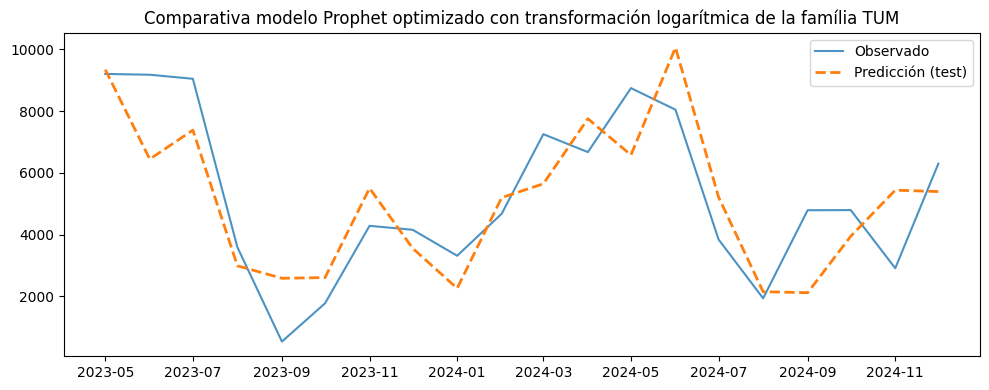

In [17]:
# === 14)  Visualización de resultados comparando observado vs predicción modelo optimizado ===

plt.figure(figsize=(10,4)) # Tamaño de la figura
plt.plot(index_values, y_real_lin_optimo, label="Observado", alpha=0.8) # Línea del valor observado
plt.plot(index_values, y_pred_lin_optimo, "--", label="Predicción (test)", linewidth=2) # Línea de la predicción
plt.title("Comparativa modelo Prophet optimizado con transformación logarítmica de la família TUM") # Título del gráfico
plt.legend() # Leyenda
plt.tight_layout() # Ajuste del diseño
plt.show() # Mostrar el gráfico

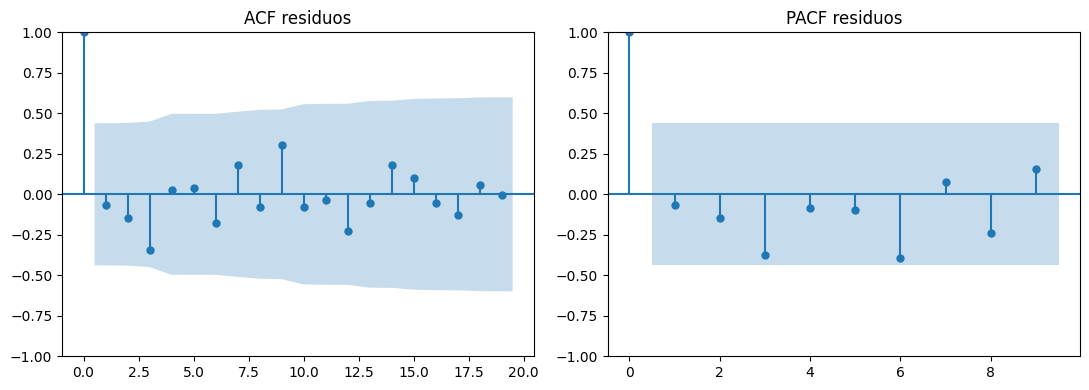

      lb_stat  lb_pvalue
19  19.761281   0.409069
9    9.674659   0.377460


In [18]:
# === 15) Análisis de los residuos del modelo optimizado ===

n = min(len(index_values), len(y_real_lin_optimo), len(y_pred_lin_optimo)) # Número de puntos de datos
# Cálculo de residuos
resid = pd.Series(
    np.asarray(y_real_lin_optimo, dtype=float) - np.asarray(y_pred_lin_optimo, dtype=float),
    index=pd.to_datetime(index_values),
    name="resid"
).dropna()
resid = resid - resid.mean() # Centrar residuos en media cero
lags_acf  = max(1, min(24, n - 1))    # Número de lags para ACF     
lags_pacf = max(1, min(24, n//2 - 1))  # Número de lags para PACF    
fig, ax = plt.subplots(1, 2, figsize=(11,4))
plot_acf(resid, lags=lags_acf, ax=ax[0])
plot_pacf(resid, lags=lags_pacf, ax=ax[1], method="ywm")
ax[0].set_title("ACF residuos")
ax[1].set_title("PACF residuos")
plt.tight_layout(); plt.show()

print(sm.stats.acorr_ljungbox(resid, lags=[lags_acf,lags_pacf], return_df=True))

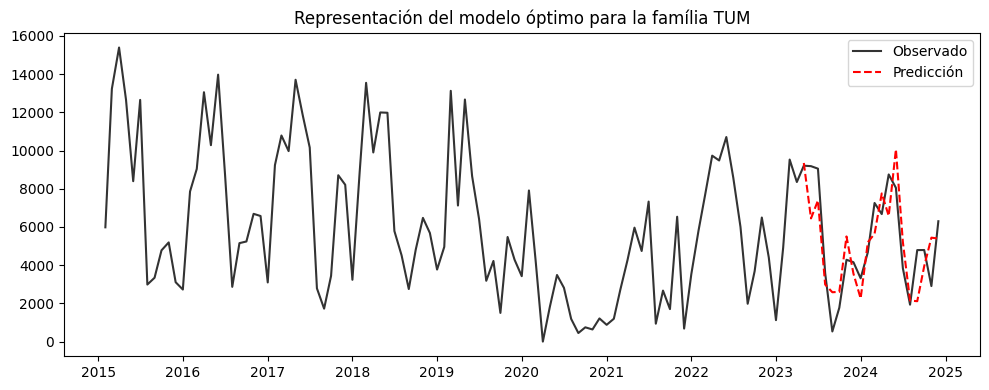

In [19]:
#== 16) Representación de la predicción del modelo óptimo completo ===

plt.figure(figsize=(10,4))
plt.plot(y, label="Observado", color="black", alpha=0.8)
plt.plot(index_values, y_pred_lin_optimo, "--", label="Predicción", color="red")
plt.title("Representación del modelo óptimo para la família TUM")
plt.legend(); plt.tight_layout(); plt.show()

Cobertura del intervalo 95% en test: 85.0%


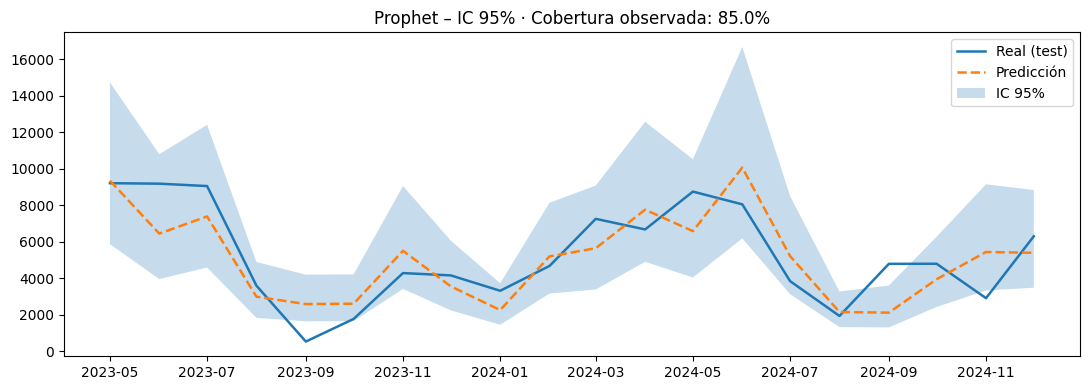

In [20]:
# === 17) Cobertura del intervalo de confianza al 95% ===

# DataFrame con valores observados y predichos en escala lineal
df_cov = test[['ds','y']].merge(inner_join[['ds','yhat_lin','lo_lin','hi_lin']], on='ds', how='inner')\
                         .set_index('ds')\
                         .rename(columns={'yhat_lin':'yhat','lo_lin':'lo','hi_lin':'hi'})

#Cobertura observada (IC 95%)
coverage = float(((df_cov['y'] >= df_cov['lo']) & (df_cov['y'] <= df_cov['hi'])).mean() * 100)
print(f"Cobertura del intervalo 95% en test: {coverage:.1f}%")

# Gráfico de la predicción con intervalo de confianza
plt.figure(figsize=(11,4))
plt.plot(df_cov.index, df_cov['y'], label='Real (test)', linewidth=1.8)
plt.plot(df_cov.index, df_cov['yhat'], '--', label='Predicción', linewidth=1.8)
plt.fill_between(df_cov.index, df_cov['lo'], df_cov['hi'], alpha=0.25, label='IC 95%')
plt.title(f"Prophet – IC 95% · Cobertura observada: {coverage:.1f}%")
plt.legend(); plt.tight_layout(); plt.show()

In [21]:
# === 18) Cálculo de métricas para el modelo base naive y_{t-12} ===

hist = df_full.set_index("ds")["y"] # Crear serie histórica completa
yhat_naive = hist.shift(12).reindex(test["ds"]).values # Desplazar 12 meses para el modelo naive
baseline_metrics = metricas(test["y"].values, yhat_naive) # Calcular métricas para el modelo naive
print("Baseline", baseline_metrics) 

Baseline {'R2': np.float64(0.280722049755852), 'RMSLE': np.float64(0.7529857378162195), 'RMSE': np.float64(2203.9068265242067), 'MAE': np.float64(1807.7), 'MAPE_safe(%)': np.float64(56.70305054009865), 'SMAPE(%)': np.float64(47.536368317089014), 'WAPE(%)': np.float64(34.424184717924305)}


In [22]:
# === 19) Cálculo de métricas para el modelo sin transformación logarítmica ===

m_sin_ln = Prophet( #   Definición del modelo Prophet
       
        seasonality_mode='additive', # Tipo de estacionalidad
        changepoint_prior_scale=CPS, # Escala de prior para puntos de cambio
        seasonality_prior_scale=SPS, # Escala de prior para estacionalidad
        interval_width=0.95 # Intervalo de confianza del 95%

    )

m_sin_ln.add_seasonality(name='anual', period=365.25, fourier_order=YEARLY_ORDER) # Añadir estacionalidad anual con Fourier


for r in cols_exog_optimas:
        m_sin_ln.add_regressor(r, prior_scale=priors_map.get(r, REGRESSOR_PRIOR), standardize=True)


m_sin_ln.fit(train) # Entrenamiento del modelo sin logaritmo


forecast_test = m_sin_ln.predict(test[["ds","Sol","Precipitación","Agosto","Tendencia","Parasol_lag1","Sillas_lag1"]]) # Predecir en el conjunto de prueba

cols_pred = ["ds"] + list(cols_exog_optimas)  # Columnas para predicción
forecast_test = m_sin_ln.predict(test[cols_pred]) # Predecir en el conjunto de prueba

# Preparar DataFrame para evaluación
eval_df = (
    pd.merge(
        test[['ds','y']], 
        forecast_test[['ds','yhat']], 
        on='ds', how='inner'
    )
    .dropna(subset=['y','yhat'])
    .reset_index(drop=True)
)

# Extraer valores reales y predichos
y_true = eval_df['y'].values
y_pred = eval_df['yhat'].values

# Calcular y mostrar métricas
res = metricas(y_true, y_pred,eps_mape=1.0)
for k, v in res.items():
    print(f"{k}: {v:.6f}")

23:07:42 - cmdstanpy - INFO - Chain [1] start processing
23:07:42 - cmdstanpy - INFO - Chain [1] done processing


R2: 0.494839
RMSLE: 0.667014
RMSE: 1846.969294
MAE: 1589.766021
MAPE_safe(%): 48.855140
SMAPE(%): 44.235401
WAPE(%): 30.274049
